In [6]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import math
# Data loading
train_data = np.load('Assignment1-Dataset/train_data.npy')
train_label = np.load('Assignment1-Dataset/train_label.npy')
test_data = np.load('Assignment1-Dataset/test_data.npy')
test_label = np.load('Assignment1-Dataset/test_label.npy')

#min max
train_min = np.min(train_data)
train_max = np.max(train_data)

adj_train_data = (train_data - train_min) / (train_max - train_min)
adj_test_data = (test_data - train_min) / (train_max - train_min)

#to consider: PCA for dimensionality reduction, which may or may not be beneficial in NN
print(train_data[1].shape)
print(train_label[1])
unique_classes = np.unique(train_label)
print(train_label)
adj_test_data = (test_data - train_min) / (train_max - train_min)
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )
    def __relu(self,x):
        return np.maximum(0,x)
    def __relu_deriv(self,a):
        # if a < 0:
        #     return 0
        # elif a > 0:
        #     return 1
        return np.where(a>0,1,0)
    def __softmax(self,x):
        exponential = np.exp(x-np.max(x,axis =-1, keepdims = True))
        ans = exponential/np.sum(exponential,axis =-1, keepdims = True)
        return ans
    def __softmax_deriv(self,yhat, y):
        return yhat-y



    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f

        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)


    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes.
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        #print(input.shape)
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output

    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) ## how much to change to get closer to target = how wrong the output was * input
        self.grad_b = np.sum(delta, axis=0) #adjust the bias based on how wrong the output was, for softmax need sum 
        if self.activation_deriv: # if its not the last layer
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input) # delta.dot(self.W.T)  = how much each neuron in the current layer is contributing to error in the next layer
        # self.activation_deriv(self.input) = measure of how much a change in each input would change the neuron’s output
        return delta # send adjusted errors back to previous layer
class MLP:
    """
    """

    # for initiallization, the code will create all layers automatically based on the provided parameters.
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output = layer.forward(input)
            input = output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-2*error*activation_deriv(y_hat)
        # return loss and delta
        return loss,delta
    
    def criterion_crossentropyloss(self,y,y_hat):
        #activation_deriv=Activation(self.activation[-1]).f_deriv
        y = np.array(y)
        #hot_encode = np.empty(len(t))
        #print(y.flatten())
        hot_encode = np.eye(10)[y.flatten()]
        y_hat = np.array(y_hat)
        t_new = hot_encode
        #print(t_new)
        y_hat = np.array(y_hat)
        Dkl = np.sum(t_new * np.log(t_new/y_hat + 0.0000001))
        crossentropy = Dkl
        delta = (y_hat - t_new) 
        return crossentropy,delta

        



    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        #print('this is to check y', y)
        to_return = np.zeros(epochs)

        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                # forward pass
                y_hat = self.forward(X[i])
                # backward pass
                loss[it],delta=self.criterion_crossentropyloss(y[i],y_hat)
                #print('next')
               
                self.backward(delta)
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:]))
        output = np.asarray(output)
        return output
### Try different MLP models
nn = MLP([128,64,64,10], [None,'relu','relu','softmax'])
input_data = adj_train_data
output_data = train_label


# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate=0.001, epochs=500)

#print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

(128,)
[9]
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [11]:
print(output.shape)
print(output_data.shape)

(50000, 10)
(50000, 1)


In [14]:
import matplotlib.pyplot as pl


loss:1.410981


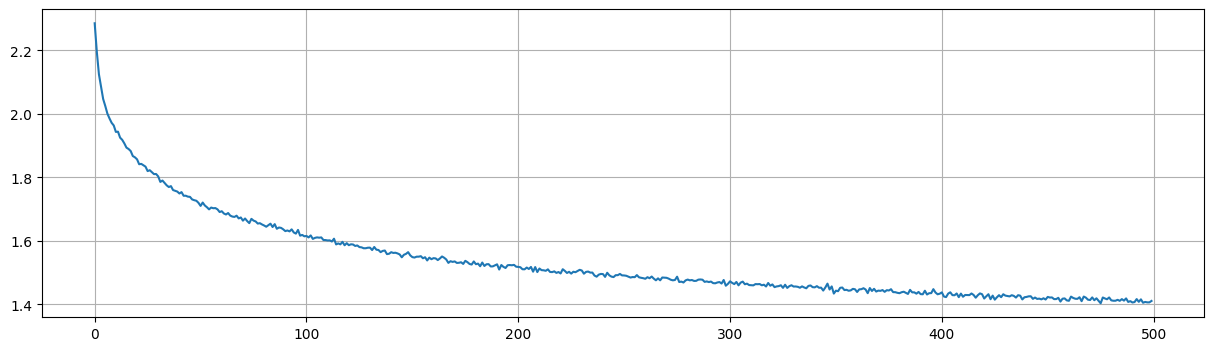

In [13]:

print('loss:%f'%cross_entropy[-1])
pl.figure(figsize=(15,4))
pl.plot(cross_entropy)
pl.grid()